In [13]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
projectId = "judini-python-main"
folder_path = "../../test_files/"
nodes_path = f"{folder_path}/{projectId}/nodes.json"
links_path = f"{folder_path}/{projectId}/links.json"






In [14]:
# Function to read JSON files
def read_json_graph(file_path):
    with open(file_path, 'r',encoding="utf8") as file:
        return json.load(file)
def save_json_graph(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)
# Function to construct graph from nodes and links
def construct_graph_from_json(nodes, links):
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node['id'], **node)
    for link in links:
        G.add_edge(link['source'], link['target'], **link)
    return G

def graph_to_csv(name='codebase'):
    nodes = pd.read_json(nodes_path)
    print(len(nodes))
    nodes['full_name'] = nodes['id']
    edges = pd.read_json(links_path)
    new_nodes = pd.DataFrame({
    "full_name": nodes["id"],
    "type": nodes["type"]})
    
    new_nodes.to_csv(f'nodes_{name}.csv', index=False)
    edges.to_csv(f'edges_{name}.csv', index=False)


In [15]:
# Read nodes and links from JSON files

nodes = read_json_graph(nodes_path)

links = read_json_graph(links_path)
graph_to_csv("vicuna")

G = construct_graph_from_json(nodes, links)

degree_dict = dict(G.degree())



# Subgraphs for "defines" and "calls"
G_defines = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'defines')
G_calls = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'calls')


# Centralities Main Graph
degree_centrality = nx.degree_centrality(G)

#indegree_centrality = nx.in_degree_centrality(G)
#outdegree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pagerank = nx.pagerank(G)
hits = nx.hits(G)
eigenvector_centrality = nx.eigenvector_centrality(G,10000)

# indegree and outdegree centralities for "defines" and "calls"
indegree_centrality_defines = nx.in_degree_centrality(G_defines)
outdegree_centrality_defines = nx.out_degree_centrality(G_defines)
indegree_centrality_calls = nx.in_degree_centrality(G_calls)
outdegree_centrality_calls = nx.out_degree_centrality(G_calls)

# Print or use the centrality meaxs_filesures
print('Degree Centrality:', degree_centrality)
#print("In Degree Centrality:", indegree_centrality)
#print("Out Degree Centrality:", outdegree_centrality)
print('Betweenness Centrality:', betweenness_centrality)
print('Closeness Centrality:', closeness_centrality)
print('PageRank:', pagerank)
print('Hubs:', hits[0])
print('Authorities:', hits[1])
print('Eigenvector Centrality:', eigenvector_centrality)
#print("Keys: ",degree_centrality.keys())

save_json_graph(degree_centrality,"degree_centrality.json")
node_list = list(degree_centrality.keys())
#print(node_list)
#print("LEN",len(node_list))
df = pd.DataFrame({
    'degree': pd.Series(degree_centrality),
    "indegree_defines": pd.Series(indegree_centrality_defines),
    'outdegree_defines': pd.Series(outdegree_centrality_defines),
    'indegree_calls': pd.Series(indegree_centrality_calls),
    'outdegree_calls': pd.Series(outdegree_centrality_calls),
    'betweenness': pd.Series(betweenness_centrality),
    'closeness': pd.Series(closeness_centrality),
    'pagerank': pd.Series(pagerank),
    'hubs': pd.Series(hits[0]), #Hub: A node is high-quality if it links to many high-quality nodes
    'authorities': pd.Series(hits[1]), #Authority: A node is high-quality if many high-quality nodes link to it
    'eigenvector': pd.Series(eigenvector_centrality),
    
})


df.index.name = 'Node'
# Set the 'NodeID' column as the new index
#df.set_index('NodeID', inplace=True)
# Normalize the centrality measures
#df = (df - df.min()) / (df.max() - df.min())

df.to_json("df.json",orient='index', indent=4)
# Sum the normalized centrality
df['combined_score'] = df.sum(axis=1)
df["combined_score"] = df.sum(axis=1)

#Separate
df_files = df[~df.index.str.contains(':')]
df_nodes = df[df.index.str.contains(':')]


# Sort the nodes and files by the combined score
most_important_nodes = df_nodes.sort_values(by='degree', ascending=False)
most_important_files = df_files.sort_values(by='combined_score', ascending=False)
#print('Most Important Nodes:', most_important_nodes)

most_important_nodes.to_csv(f'{projectId}-important-nodes.csv',index_label='Node')
most_important_files.to_csv(f'{projectId}-important-files.csv',index_label='Node')



36
Degree Centrality: {'judini-python-main\\examples\\chat_completion::chat_example': 0.02857142857142857, 'judini-python-main\\examples\\chat_completion': 0.02857142857142857, 'judini-python-main\\setup': 0.0, 'judini-python-main\\src\\judini\\__init__': 0.0, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.delete_document': 0.08571428571428572, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.upload_document': 0.14285714285714285, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus._generate_document_metadata': 0.11428571428571428, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.update_document_metadata': 0.14285714285714285, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.get_document': 0.11428571428571428, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.get_documents': 0.08571428571428572, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.update_agent_documents': 0.08571428571428572, 'judini-python-main\\src\\judini\\codegpt::CodeGPTPlus.del

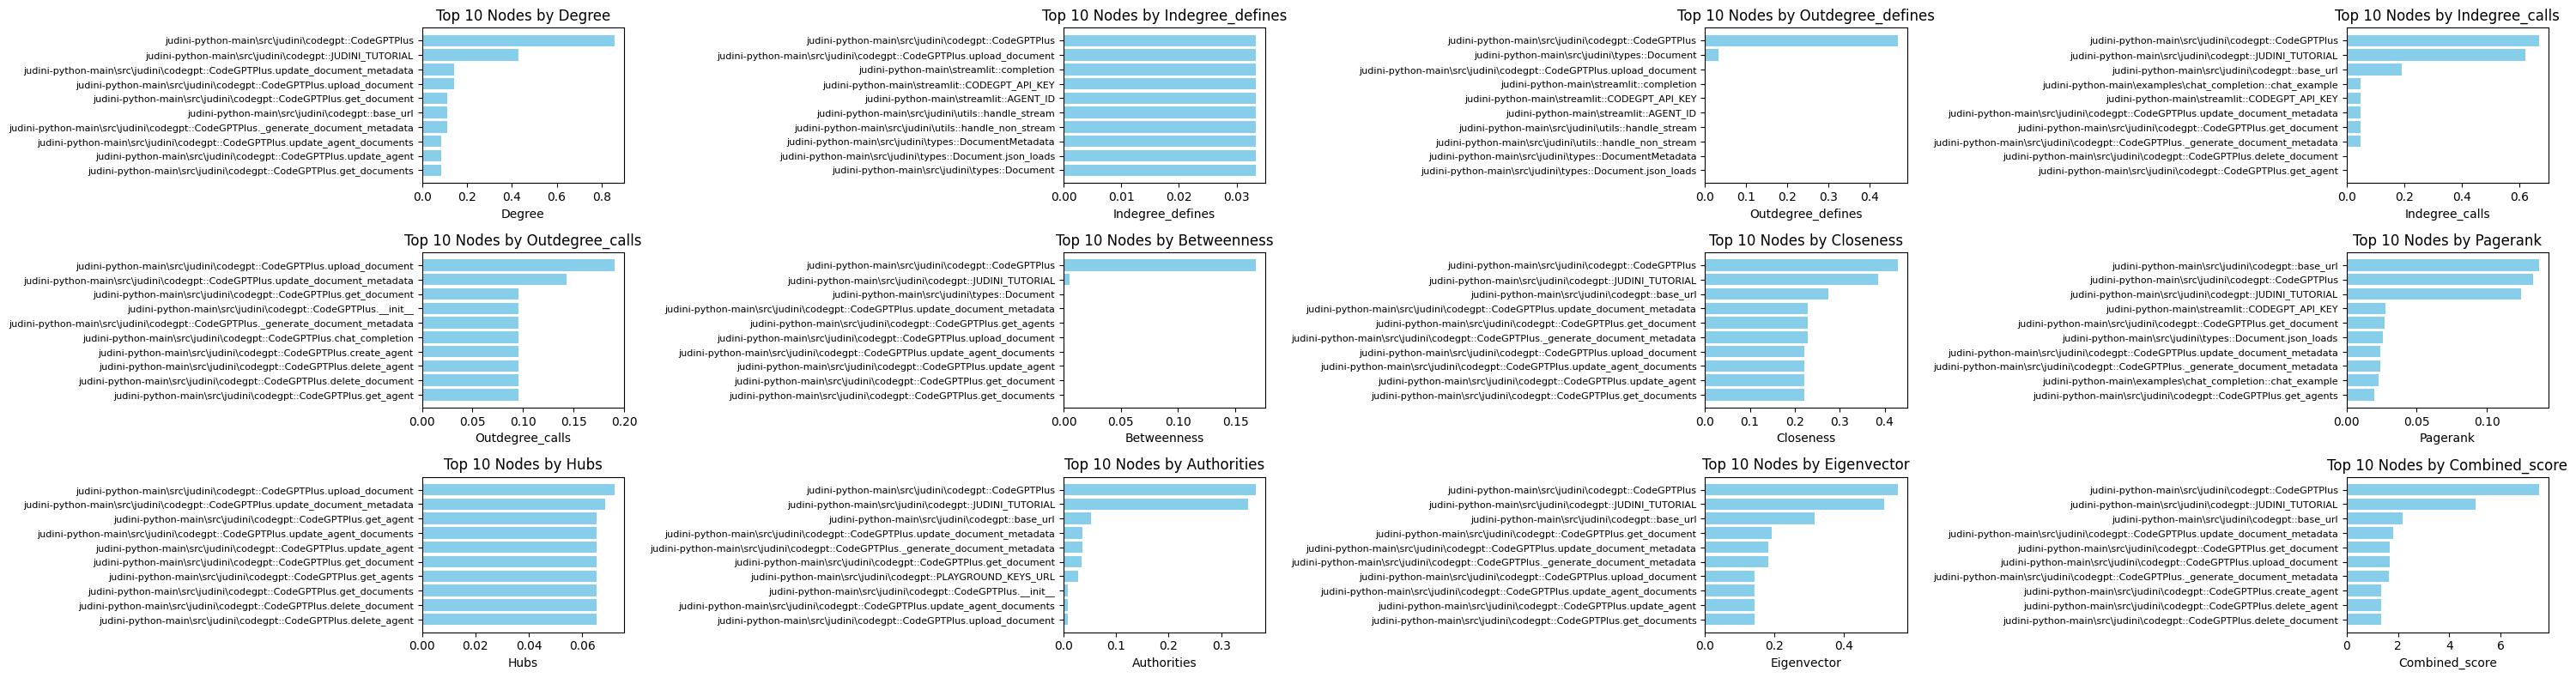

In [16]:

# Metrics to plot
metrics = ['degree', "indegree_defines", "outdegree_defines","indegree_calls", "outdegree_calls",'betweenness', 'closeness', 'pagerank', 'hubs', 'authorities', 'eigenvector',"combined_score"]

# Create a figure for nodes
fig_nodes, axs_nodes = plt.subplots(nrows=3, ncols=4, figsize=(30, 8))

axs_nodes = axs_nodes.flatten()

# Plotting each metric for top 10 nodes
for i, metric in enumerate(metrics):
    top_10_nodes = df_nodes.sort_values(by=metric, ascending=False).head(10)
    
    # Plotting top 10 nodes
    axs_nodes[i].barh(top_10_nodes.index, top_10_nodes[metric], color='skyblue')
    axs_nodes[i].set_xlabel(metric.capitalize())
    axs_nodes[i].set_title(f'Top 10 Nodes by {metric.capitalize()}')
    axs_nodes[i].invert_yaxis()  # To display the highest centrality at the top
    axs_nodes[i].tick_params(axis='y', labelsize=8)

fig_nodes.tight_layout()
plt.show()

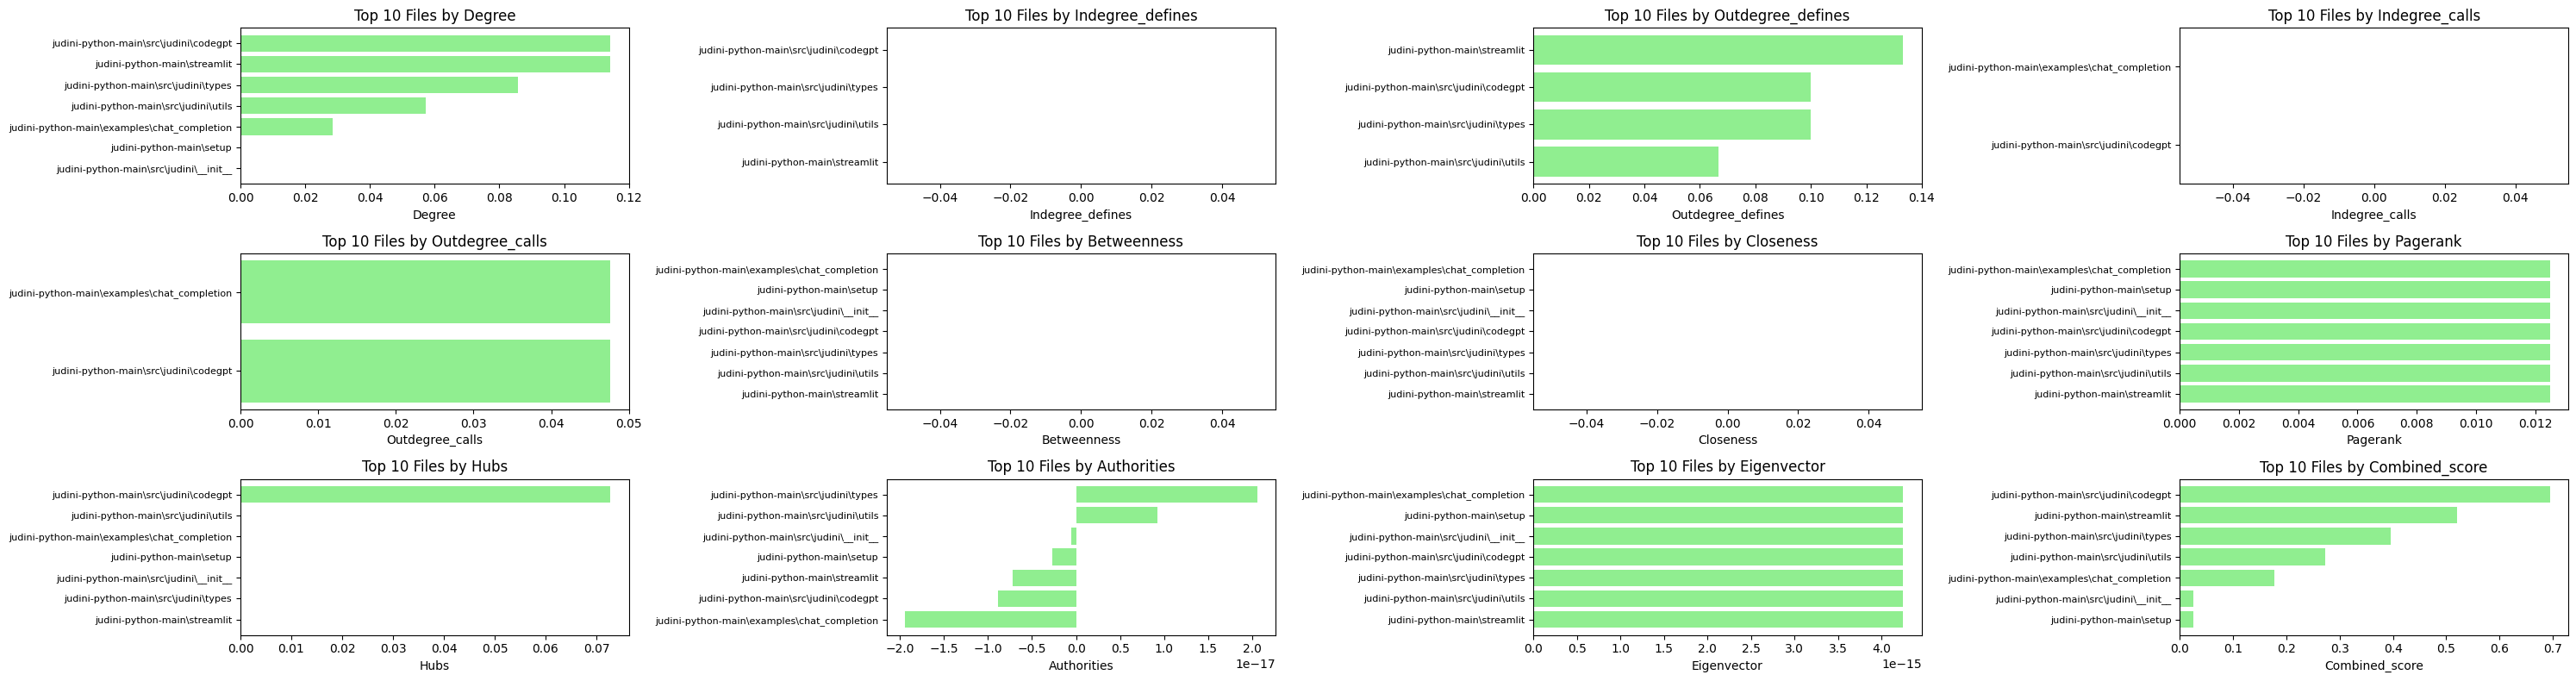

In [17]:
fig_files, axs_files = plt.subplots(nrows=3, ncols=4, figsize=(30, 8))
axs_files = axs_files.flatten()
# Plotting each metric for top 10 files
for i, metric in enumerate(metrics):
    top_10_files = df_files.sort_values(by=metric, ascending=False).head(10)
    
    # Plotting top 10 files
    axs_files[i].barh(top_10_files.index, top_10_files[metric], color='lightgreen')
    axs_files[i].set_xlabel(metric.capitalize())
    axs_files[i].set_title(f'Top 10 Files by {metric.capitalize()}')
    axs_files[i].invert_yaxis()  # To display the highest centrality at the top
    axs_files[i].tick_params(axis='y', labelsize=8)

fig_files.tight_layout()
plt.show()